In [1]:
import pandas as pd
import tqdm
import functools
import numpy as np

In [2]:
from rdkit.Chem import PandasTools

In [3]:
# from kinodata.data.io.read_klifs_mol2 import read_klifs_mol2
from pathlib import Path
from typing import Union
import pandas as pd
import numpy as np
import re

try:
    from biopandas.mol2 import PandasMol2

    pmol = PandasMol2()
except:
    print("i am so tired of rebuilding my entire docker image every single time")

klifs_mol2_columns = {
    0: ("atom.id", "int32"),
    1: ("atom.name", "string"),
    2: ("atom.x", "float32"),
    3: ("atom.y", "float32"),
    4: ("atom.z", "float32"),
    5: ("atom.type", "string"),
    6: ("residue.subst_id", "int32"),
    7: ("residue.subst_name", "string"),
    8: ("atom.charge", "float32"),
    9: ("atom.status_bit", "string"),
}

@functools.cache
def read_klifs_mol2(path: Union[str, Path], with_bonds: bool = True) -> pd.DataFrame:
    path = Path(path)
    atom_df = pmol.read_mol2(str(path), columns=klifs_mol2_columns).df
    if with_bonds:
        raw = path.read_text()
        bond_start = raw.find("@<TRIPOS>BOND")
        bond_len = raw[bond_start + 1 :].find("@")
        rows = raw[bond_start : bond_start + bond_len].split("\n")[1:]
        rows = [row.rstrip().split()[:4] for row in rows]
        bond_df = pd.DataFrame(
            rows, columns=["bond_id", "source_atom_id", "target_atom_id", "bond_type"]
        )
        bond_df["bond_id"] = bond_df["bond_id"].astype(int)
        bond_df["source_atom_id"] = bond_df["source_atom_id"].astype(int)
        bond_df["target_atom_id"] = bond_df["target_atom_id"].astype(int)
        return atom_df, bond_df
    return atom_df

In [4]:
res_elim = pd.read_csv('../data/snack_box.csv', index_col=0)
res_elim['delta'] = res_elim['reference_pred'] - res_elim['masked_pred']
res_elim.head()

,ident,masked_residue,masked_pred,compound_structures.canonical_smiles,docking.chemgauss_score,similar.klifs_structure_id,similar.fp_similarity,activities.activity_id,UniprotID,docking.posit_probability,docking.predicted_rmsd,index,reference_pred,target,delta
0,44494,72,5.676785,Nc1n[nH]c2nc(-c3ccc(NS(=O)(=O)c4cc(Cl)ccc4Cl)c...,-11.868353,14012,0.271318,13852678,O00141,0.78,1.382647,0,5.666315,4.376751,-0.010470
1,44494,71,5.657371,Nc1n[nH]c2nc(-c3ccc(NS(=O)(=O)c4cc(Cl)ccc4Cl)c...,-11.868353,14012,0.271318,13852678,O00141,0.78,1.382647,0,5.666315,4.376751,0.008944
2,44494,60,5.628484,Nc1n[nH]c2nc(-c3ccc(NS(=O)(=O)c4cc(Cl)ccc4Cl)c...,-11.868353,14012,0.271318,13852678,O00141,0.78,1.382647,0,5.666315,4.376751,0.037831
3,44494,61,5.688464,Nc1n[nH]c2nc(-c3ccc(NS(=O)(=O)c4cc(Cl)ccc4Cl)c...,-11.868353,14012,0.271318,13852678,O00141,0.78,1.382647,0,5.666315,4.376751,-0.022149
4,44494,25,5.675944,Nc1n[nH]c2nc(-c3ccc(NS(=O)(=O)c4cc(Cl)ccc4Cl)c...,-11.868353,14012,0.271318,13852678,O00141,0.78,1.382647,0,5.666315,4.376751,-0.009629


In [5]:
pocketfile = lambda ident: f'../data/raw/mol2/pocket/{df.loc[ident]["similar.klifs_structure_id"]}_pocket.mol2'
pockets = []
for ident in tqdm.tqdm(res_elim['similar.klifs_structure_id'].unique()):
    # struc_id = res_elim.set_index('ident').loc[ident].iloc[0]["similar.klifs_structure_id"]
    pocket_df = read_klifs_mol2(f'../data/raw/mol2/pocket/{ident}_pocket.mol2', with_bonds=False)
    non_hydrogen = pocket_df["atom.type"] != "H"
    pocket_df = pocket_df[non_hydrogen].reset_index()
    pocket_df["atom_id"] = pocket_df.index
    pocket_df["similar.klifs_structure_id"] = ident
    pockets.append(pocket_df)
pockets = pd.concat(pockets)

100%|███████████████████████████████████████| 2232/2232 [00:23<00:00, 95.31it/s]


In [6]:
# pockets.to_csv('pockets.csv', index=False
pockets = pd.read_csv('pockets.csv', index_col=False)

In [7]:
kd = PandasTools.LoadSDF('../data/raw/kinodata_docked_v2.sdf.gz')

In [8]:
kd = kd.astype({'activities.activity_id': int})
kd.set_index('activities.activity_id', inplace=True)

In [9]:
# res_elim['pl_com_dist'] = np.inf
res_elim['pl_min_dist'] = np.nan
res_elim['ca_min_dist'] = np.nan

<AxesSubplot: >

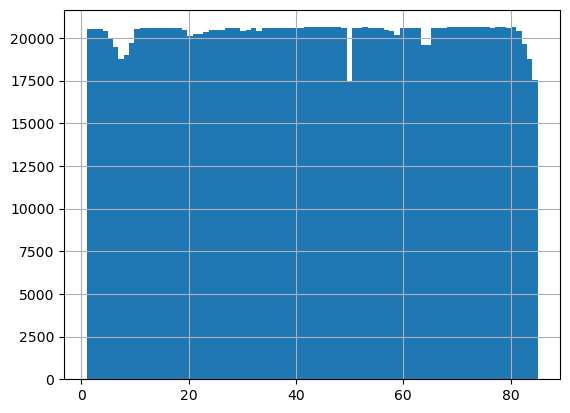

In [10]:
res_elim['masked_residue'].hist(bins=85)

In [11]:
pockets.set_index('similar.klifs_structure_id', inplace=True)

In [12]:
def atom_positions(mol):
    conf = mol.GetConformer()
    positions = np.array([np.array(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])
    return positions

In [13]:
def min_dist(A, B):
    diff = A[:, np.newaxis, :] - B[np.newaxis, :, :]
    sq_dists = np.sum(diff ** 2, axis=2)
    min_sq_dist = np.min(sq_dists)
    return np.sqrt(min_sq_dist)

In [14]:
res_elim.reset_index(inplace=True)
res_elim.set_index(['activities.activity_id', 'masked_residue'], inplace=True)
res_elim.sort_index(inplace=True)

In [15]:
res_elim['resname'] = ''
res_elim['rescode'] = ''

In [16]:
protein_letters_3to1 = {
  "ALA": "A",
  "CYS": "C",
  "ASP": "D",
  "GLU": "E",
  "PHE": "F",
  "GLY": "G",
  "HIS": "H",
  "ILE": "I",
  "LYS": "K",
  "LEU": "L",
  "MET": "M",
  "ASN": "N",
  "PRO": "P",
  "GLN": "Q",
  "ARG": "R",
  "SER": "S",
  "THR": "T",
  "VAL": "V",
  "TRP": "W",
  "TYR": "Y",
}

In [17]:
resnames = []

In [18]:
res_elim['resname'] = -1

In [ ]:
for ident, group in tqdm.tqdm(res_elim.groupby('activities.activity_id'), total=20620):
    try:
        mol = kd.loc[ident, 'ROMol']
    except:
        continue

    # ligand atom positions
    apos = atom_positions(mol)
    residues = group.index.get_level_values(1).values
    klifs_id = group['similar.klifs_structure_id'].unique()[0]
    for resnum, (resid, res_grp) in zip(residues, pockets.loc[klifs_id].groupby('residue.subst_id')):
        # residue atom positions
        ppos = res_grp[['atom.x', 'atom.y', 'atom.z']].values
        capos = res_grp[res_grp['atom.name'] == 'CA'][['atom.x', 'atom.y', 'atom.z']].values
        
        res_elim.loc[(ident, resnum), 'pl_min_dist'] = min_dist(ppos, apos)
        res_elim.loc[(ident, resnum), 'ca_min_dist'] = np.nan if len(capos) == 0 else min_dist(capos, apos)

        resname = res_grp.iloc[0]['residue.subst_name'][:3]
        if resname not in resnames:
            resnames.append(resname)
        res_elim.loc[(ident, resnum), 'resname'] = resnames.index(resname)
        # res_elim.loc[(ident, resnum), 'resname'] = resname
        # res_elim.loc[(ident, resnum), 'rescode'] = protein_letters_3to1.get(resname, 'X')

 96%|███████████████████████████████████▌ | 19800/20620 [59:52<02:36,  5.23it/s]

In [ ]:
res_elim[['pl_min_dist', 'ca_min_dist']].hist(bins=100)

In [ ]:
res_elim.reset_index().to_csv('res_elim_new.csv', index=False)